In [1]:
#!pip install CAMB
#!pip install Pylians
#!pip install astropy

!pip install healpy
'''
!apt install cm-super
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash

!pip install SciencePlots
'''
from google.colab import drive
drive.mount('/content/drive')
#The command below is to bring the program where I define the function that generates the 3d field
#!cp /content/drive/MyDrive/espectro_potencia/map2volum.py .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 27.5 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
'''
import scienceplots
plt.style.use('science')
plt.rcParams.update({'figure.dpi': '300'})
'''

from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy.io import fits
import os
import shutil

In [12]:
#LEITURA DOS MAPAS SIMULADOS E CRIAÇÃO CATÁLOGO TOTAL
#path0='/content/drive/MyDrive/mapas/des_simulador/sample0/contagem/'
#path1='/content/drive/MyDrive/mapas/des_simulador/sample1/contagem/'
pathdt = '/content/drive/MyDrive/mapas/des_16_01/'
path0  = pathdt+'sample0/contagem/'
path1  = pathdt+'sample1/contagem/'
pathd0 = pathdt+'sample0/densidade/'
pathd1 = pathdt+'sample1/densidade/'

if os.path.exists(pathdt+'dens_total'):
    shutil.rmtree(pathdt+'dens_total')
os.makedirs(pathdt+'dens_total')

mask = hp.read_map('/content/drive/MyDrive/mapas/DES_256_RING.fits')

cat0 = np.zeros(12*256**2)
cat1 = np.zeros(12*256**2)
catd = np.zeros(12*256**2)
catm = np.zeros(12*256**2)


number_per_catalog0 = np.zeros(30)
number_per_catalog1 = np.zeros(30)

cosmo = FlatLambdaCDM(Om0=0.26,H0=72)
volume = cosmo.comoving_volume(0.449).value-cosmo.comoving_volume(0.127).value
volume = volume/(12*256**2)

for i in range(0,30):
  s0 = np.load(path0 + str(i) + 'Mhz.npy')
  s1 = np.load(path1 + str(i) + 'Mhz.npy')
  d0 = np.load(pathd0 + str(i) + 'Mhz.npy')
  d1 = np.load(pathd1 + str(i) + 'Mhz.npy')
  d30 = d0 + d1
  np.save(pathdt+'dens_total/'+str(i)+'Mhz.npy',d30)
  catd = catd + s0 + s1
  for j in range(0,12*256**2):
    if mask[j]<0:
      s0[j] = 0
      s1[j] = 0
  number_per_catalog0[i] = np.sum(s0)
  number_per_catalog1[i] = np.sum(s1)
  #dd  = d0  + d1

  cat0 = cat0 + s0
  cat1 = cat1 + s1

catd = catd/volume

np.save(pathdt+'dens_total_gal.npy',catd)
#np.save(pathdt+'dens_total_masked.npy',catm)

In [5]:
#DADOS DES
cat = fits.open('/content/drive/MyDrive/tutoriais/y3a2_gold2.2.1_redmagic_highdens.fits')
hdr = cat[1].header
ra     = cat[1].data['ra      ']           #right ascencion in degrees
dec    = cat[1].data['dec     ']           #declination in radians
red    = cat[1].data['zredmagic']          #galaxies redshifts
erro   = cat[1].data['zredmagic_e']        #redshift errors
bin_t  = cat[1].data['bin_number']         #bin which contain the respective galaxy - values 1,2,3

#selecionando os objetos por bin
z1=red[bin_t==1]
z2=red[bin_t==2]
z3=red[bin_t==3]

def app_error(redshift,erro):
    for j in range(0,len(erro)):
        redshift[j]=redshift[j]+erro[j]*np.random.normal(0,1)
    return redshift

red_com_erro = app_error(red,erro)

z1_erro=red_com_erro[bin_t==1]
z2_erro=red_com_erro[bin_t==2]
z3_erro=red_com_erro[bin_t==3]

def norm_dist(sample,n):
    u=np.linspace(min(sample),max(sample),n)
    red,bins=np.histogram(sample,n)
    red=np.multiply(red,1/(len(sample)*(u[2]-u[1])))
    return u,red

def makeHealpixMap(ra, dec, nside=1024, nest=False):
    # convert a ra/dec catalog into healpix map with counts per cell
    import healpy as hp
    ipix = hp.ang2pix(nside, (90-dec)/180*np.pi, ra/180*np.pi, nest=nest)
    return np.bincount(ipix, minlength=hp.nside2npix(nside)) 

In [6]:
#PLOT MOLLVIEWS
'''
mask = hp.read_map('/content/drive/MyDrive/mapas/mascaras/DES_256_RING.fits')
#real:
rar = ra[red<0.42]
decr = dec[red<0.42]
mapa = np.asarray(makeHealpixMap(rar, decr, nside=256, nest=False)).astype(np.float32)
for i in range(0,len(mask)):
  if mask[i]<0:
    mapa[i]=mask[i]
  else:
    mapa[i]=mapa[i]*mask[i]
hp.mollview(mapa, title= 'DES - Dados reais - [0.12-0.45]', unit='Number of galaxies',format='%.f')
hp.graticule()
plt.savefig('/content/drive/MyDrive/imagens/resultados/mollview_des_real.png')

#simulado
catnt = cat0 + cat1
for i in range(0,len(mask)):
  if mask[i]<0:
    catnt[i]=mask[i]
  else:
    catnt[i]=catnt[i]*mask[i]
hp.mollview(catnt, title= 'DES - Simulação - [0.12-0.45]', unit='Number of galaxies',format='%.f',max=37)
hp.graticule()
plt.savefig('/content/drive/MyDrive/imagens/resultados/mollview_des_simu.png')
'''

"\nmask = hp.read_map('/content/drive/MyDrive/mapas/mascaras/DES_256_RING.fits')\n#real:\nrar = ra[red<0.42]\ndecr = dec[red<0.42]\nmapa = np.asarray(makeHealpixMap(rar, decr, nside=256, nest=False)).astype(np.float32)\nfor i in range(0,len(mask)):\n  if mask[i]<0:\n    mapa[i]=mask[i]\n  else:\n    mapa[i]=mapa[i]*mask[i]\nhp.mollview(mapa, title= 'DES - Dados reais - [0.12-0.45]', unit='Number of galaxies',format='%.f')\nhp.graticule()\nplt.savefig('/content/drive/MyDrive/imagens/resultados/mollview_des_real.png')\n\n#simulado\ncatnt = cat0 + cat1\nfor i in range(0,len(mask)):\n  if mask[i]<0:\n    catnt[i]=mask[i]\n  else:\n    catnt[i]=catnt[i]*mask[i]\nhp.mollview(catnt, title= 'DES - Simulação - [0.12-0.45]', unit='Number of galaxies',format='%.f',max=37)\nhp.graticule()\nplt.savefig('/content/drive/MyDrive/imagens/resultados/mollview_des_simu.png')\n"

In [7]:
larg = (0.449-0.127)/30
red = np.linspace(0.127+larg/2,0.449-larg/2,30)

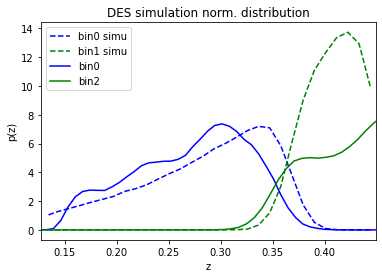

In [8]:
larg = (0.449-0.127)/30
red = np.linspace(0.449-larg/2,0.127+larg/2,30)

n=100
u1,red1 = norm_dist(z1_erro,n)
u2,red2 = norm_dist(z2_erro,n)
u3,red3 = norm_dist(z3_erro,n)

plt.plot(red,number_per_catalog0/(larg*np.sum(cat0)),color='b',label='bin0 simu',linestyle='--')
plt.plot(red,number_per_catalog1/(larg*np.sum(cat1)),color='g',label='bin1 simu',linestyle='--')
plt.plot(u1,red1,color='b',label='bin0')
plt.plot(u2,red2,color='g',label='bin2')
plt.ylabel('p(z)')
plt.xlabel('z')
plt.xlim(0.127,0.449)
plt.legend()
plt.title('DES simulation norm. distribution')
plt.show()

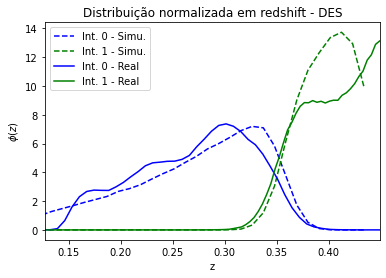

In [9]:
z2_menor = []
for i in range(0,len(z2)):
  if z2_erro[i]<0.449:
    z2_menor.append(z2_erro[i])

n=100
u1,red1 = norm_dist(z1_erro,n)
u2,red2 = norm_dist(z2_menor,n)
#preciso deslocar 0.01 para trás pq no simu pego no final do intervalo
plt.plot(red-0.01,number_per_catalog0/(larg*np.sum(cat0)),color='b',label='Int. 0 - Simu.',linestyle='--')
plt.plot(red-0.01,number_per_catalog1/(larg*np.sum(cat1)),color='g',label='Int. 1 - Simu.',linestyle='--')
plt.plot(u1,red1,color='b',label='Int. 0 - Real')
plt.plot(u2,red2,color='g',label='Int. 1 - Real')
plt.ylabel('$\phi(z)$')
plt.xlabel('z')
plt.legend()
plt.xlim(0.127,0.449)
plt.title('Distribuição normalizada em redshift - DES')
plt.show()
#plt.savefig('/content/drive/MyDrive/imagens/resultados/norm_red_dist.png')

In [10]:
#Número de objetos
print('Número Bin 0 real',len(z1))
print('Número Bin 1 real',len(z2))
print('Número Bin 0 simulado',np.sum(cat0))
print('Número Bin 1 simulado',np.sum(cat1))
print('Número Bin 1 real z<0.449',len(z2_menor))


#Cálculo densidade média por ângulo sólido
area = 4250
area_arcmin = area*60*60

#DES real
dens_area0 = len(z1)/area_arcmin
dens_area1 = len(z2)/area_arcmin

print('Densidade bin 0 real:', dens_area0)
print('Densidade bin 1 real:', dens_area1)

#DES simulado
dens_simu0 = np.sum(cat0)/area_arcmin
dens_simu1 = np.sum(cat1)/area_arcmin

print('Densidade bin 0 simu:', dens_simu0)
print('Densidade bin 1 simu:', dens_simu1)

#DES simulado corrigido
dens_simu0 = np.sum(cat0)/area_arcmin
dens_simu_corr1 = len(z2_menor)/area_arcmin

#print('Densidade bin 0 simu:', dens_simu0)
print('Densidade bin 1 real z<0.449:', dens_simu_corr1)

Número Bin 0 real 342347
Número Bin 1 real 591381
Número Bin 0 simulado 221387.0
Número Bin 1 simulado 209670.0
Número Bin 1 real z<0.449 332331
Densidade bin 0 real: 0.02237562091503268
Densidade bin 1 real: 0.03865235294117647
Densidade bin 0 simu: 0.014469738562091503
Densidade bin 1 simu: 0.013703921568627452
Densidade bin 1 real z<0.449: 0.021720980392156863
